### 학습목표
1. 푸쉬 노티피케이션 타임 의사 결정 하기

In [1]:
import numpy as np
import pandas as pd
# seaborn
import seaborn as sns
COLORS = sns.color_palette()

%matplotlib inline

In [2]:
def plot_bar(df, xlabel, ylabel, title, figsize=(20, 10), color=COLORS[-1], rotation=45):
    plot = df.plot(kind='bar', color=color, figsize=figsize)
    plot.set_xlabel(xlabel, fontsize=10)
    plot.set_ylabel(ylabel, fontsize=10)
    plot.set_title(title, fontsize=12)
    plot.set_xticklabels(labels=df.index, rotation=rotation)

In [4]:
dtypes = {
    'UnitPrice': np.float32,
    'CustomerID': np.int32,
    'Quantity': np.int32
}
retail = pd.read_csv('../Data/OnlineRetailClean.csv', dtype=dtypes)
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], infer_datetime_format=True)
retail.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### 쿠폰 발송을 할때, push를 언제 보내는게 좋을까?
 - 고객에게 쿠폰 발송을 한다고 기획하고, 회의를 한다고 가정해보겠습니다. 
  - A: 쿠폰을 언제보내는게 좋을까요?
  - B: 아침에 출퇴근 시간에 보내는게 좋을까요?
  - C: 점심 먹고 졸린데 그때 보내보죠?
  - D: 흠 자기전에 스마트폰 많이 하던데 그때는 어떨까요?
  - A: 그러면 평균 시간을 내볼까요?
  - K: 아 **데이터**를 확인해보는게 맞지 않을까요? 언제 고객이 주로 주문을 하는지? 


 - 위에서 처럼 실제로 회의를 하다보면 의사결정이 본인/주변의 경험에 의해서 이뤄지는 것을 많이 볼 수 있습니다. 
 - 주문이 이뤄지는 시간을 고려하지 않고 막무가내로 보낸다면 아무 의미가 없고, 추후 같은 이벤트 발생시에도 판단 근거가 없게 됨
 - 현상태에서는 가장 많이 주문이 일어나는 시점에서 하는 것이 가장 직관적인 판단
   - 1. 데이터로 파악
   - 2. 가설 제시
   - 3. 가설 검증
   - 4. 1-3 반복
 - 시간(hour, minute)과 주로 관련되기 때문에 역시 InvoiceDate가 중요한 feature
   

In [6]:
order_by_hour = retail.set_index('InvoiceDate').groupby(lambda date:date.hour).count()['CustomerID']
order_by_hour

6         1
7       379
8      8690
9     21944
10    37997
11    49084
12    72065
13    64026
14    54118
15    45369
16    24089
17    13071
18     2928
19     3321
20      802
Name: CustomerID, dtype: int64

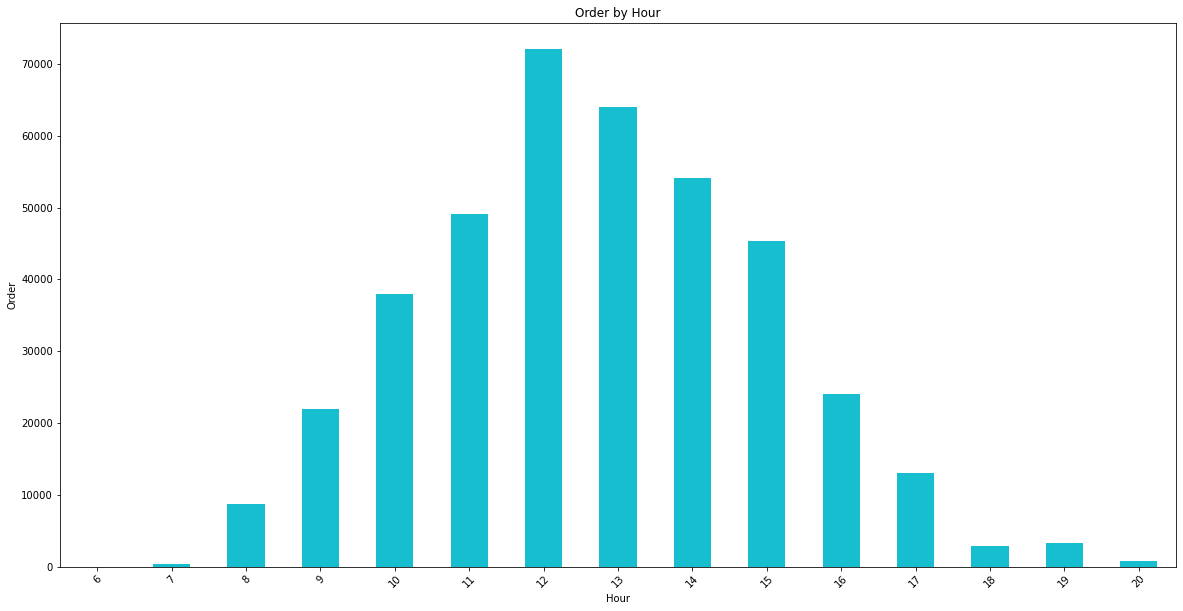

In [7]:
plot_bar(order_by_hour,'Hour','Order','Order by Hour')

In [8]:
def half_hour(date):
    minute = ':00'
    if date.minute > 30:
        minute = ':30'
    hour = str(date.hour)
    if date.hour < 10 :
        hour = '0' + hour
        
    return hour + minute

In [10]:
order_by_hour_half = retail.set_index('InvoiceDate').groupby(half_hour).count()['CustomerID']


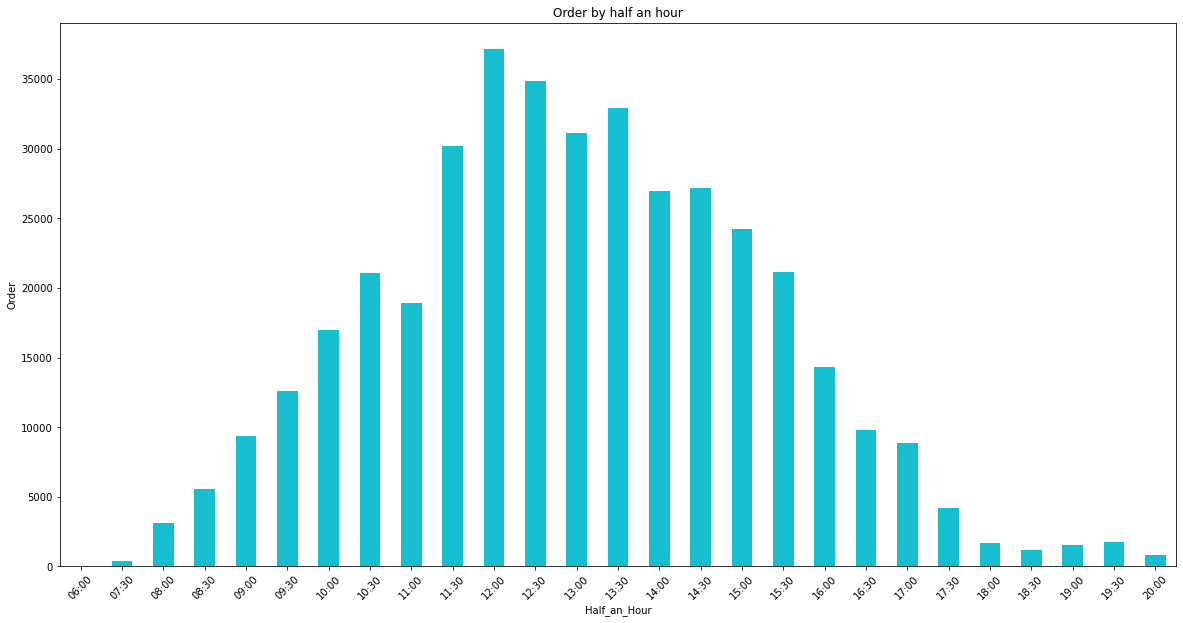

In [12]:
plot_bar(order_by_hour_half,'Half_an_Hour','Order','Order by half an hour')

#### 개인화된 push notification
 - 아마존을 필두로, 개인화(personalization)하여 맞춤으로 사용자마다 최적의 솔루션을 찾는것이 트렌드가 됨
 - 사용자별로 소비의 패턴이 다를 수 있기 때문에, 가장 많이 구매한 시간대를 찾아서 해당 시간대에 쿠폰을 발송!

#### 사용자별 각 시간별 주문 량 계산하기

In [13]:
order_count_by_hour = retail.set_index('InvoiceDate').groupby(['CustomerID',lambda date:date.hour]).count()['StockCode']
order_count_by_hour

CustomerID    
12346       10     1
12347       8     22
            10    24
            12    47
            13    18
                  ..
18283       15     1
            16    56
            19    87
18287       9      3
            10    67
Name: StockCode, Length: 11205, dtype: int64

#### 사용자별 최대 주문 시간 계산하기
 - 가장 많은 주문량을 보인 시간을 계산

In [16]:
order_count_by_hour.groupby('CustomerID').idxmax()

CustomerID
12346    (12346, 10)
12347    (12347, 14)
12348    (12348, 19)
12349     (12349, 9)
12350    (12350, 16)
            ...     
18280     (18280, 9)
18281    (18281, 10)
18282    (18282, 13)
18283    (18283, 14)
18287    (18287, 10)
Name: StockCode, Length: 4338, dtype: object

#### 해당 시간 indexing

In [ ]:
order_count_by_hour.loc